# Maine Blackout Data Analysis

In [99]:
# importing required libraries
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.options.mode.chained_assignment = None

### Import and clean data

In [100]:
# importing data
df = pd.read_csv('../data/Maine_Power.csv')

# drop all entries with an unknown county or no customer hours tracked
df.drop(df[df['CountyName'] == "Unknown"].index, inplace=True)
df.drop(df[df['CustomerHoursTrackedTotal']  <= 0].index, inplace=True)

df

,UtilityName,StateName,CountyName,CityName,AvgCustomersTracked,MaxCustomersOut,CustomerHoursOutTotal,CustomerHoursTrackedTotal,RecordYear,RecordMonth
0,Versant Power,Maine,Washington,Dennysville,188,15,12.84,140502.98,2021,1
1,Central Maine Power,Maine,Franklin,Madrid,210,21,55.74,156833.31,2021,12
2,Central Maine Power,Maine,Lincoln,Hibberts Gore,1,1,0.00,717.41,2023,7
3,Central Maine Power,Maine,Franklin,Farmington,4009,83,57.34,2982696.00,2018,3
4,Central Maine Power,Maine,Waldo,Liberty,802,36,54.04,597100.32,2018,8
...,...,...,...,...,...,...,...,...,...,...
62032,Central Maine Power,Maine,York,Saco,11237,4691,37555.28,8360427.61,2023,1
62033,Versant Power,Maine,Penobscot,Medway,767,29,0.65,566708.17,2023,8
62035,Central Maine Power,Maine,Lincoln,Wiscasset,2378,583,3702.20,1712649.36,2020,11
62037,Eastern Maine Power Cooperative,Maine,Aroostook,Orient,26,0,0.00,19344.00,2022,1


### Table of the yearly average outage hours per customer by county

In [101]:
# sum up all the customers tracked and total customer hours by month and county
county_monthly_df = df.groupby(['CountyName', 'RecordYear', 'RecordMonth']).agg({'CustomerHoursOutTotal': 'sum', 'AvgCustomersTracked': 'sum', 'UtilityName': lambda x: ', '.join(x.unique())}).reset_index()

# sum up total customer hours out by year and county and average the customers tracked (to avoid double counting)
yearly_df = county_monthly_df.groupby(['CountyName', 'RecordYear']).agg({'CustomerHoursOutTotal': 'sum', 'AvgCustomersTracked': 'mean', 'UtilityName': lambda x: ', '.join(x.unique())}).reset_index()

# get the yearly outage hours per customer for each county
yearly_df['OutageHoursPerCustomer'] = yearly_df['CustomerHoursOutTotal'] / yearly_df['AvgCustomersTracked']

# create a final table with the relevant columns
df_yearly_cust_outage = yearly_df[['CountyName', 'RecordYear', 'OutageHoursPerCustomer', 'UtilityName']]

# sort by county and year
df_yearly_cust_outage.sort_values(by=['CountyName', 'RecordYear'], inplace=True)

# rename columns to be more readable
df_yearly_cust_outage.rename(columns={"CountyName": "County", "RecordYear": "Year", "OutageHoursPerCustomer": "Average Outage Hours per Customer"}, inplace=True)

# export and show dataframe
df_yearly_cust_outage.to_csv("exports/maine-county-yearly-out-hours-per-cust.csv", sep=',', encoding='utf-8', index=False, header=True)
df_yearly_cust_outage

,County,Year,Average Outage Hours per Customer,UtilityName
0,Androscoggin,2016,1.220995,Central Maine Power
1,Androscoggin,2017,3.093134,Central Maine Power
2,Androscoggin,2018,6.942541,Central Maine Power
3,Androscoggin,2019,5.398300,Central Maine Power
4,Androscoggin,2020,33.409456,Central Maine Power
5,Androscoggin,2021,2.992960,Central Maine Power
6,Androscoggin,2022,19.751388,Central Maine Power
7,Androscoggin,2023,4.527381,Central Maine Power
8,Aroostook,2017,121.646927,Versant Power
9,Aroostook,2018,39.249731,"Versant Power, Versant Power, Eastern Maine Po..."


### Create a choropleth map of average outage hours per customer by county

In [102]:
# Aroostok county only has data from 2017 onwards, removing data from 2016 and earlier for consistency
yearly_df.drop(yearly_df[yearly_df['RecordYear'] <= 2016].index, inplace=True)

# Function that removes duplicate utility providers from entries
def remove_duplicate_providers(providers_str):
    providers = set(provider.strip() for provider in providers_str.split(', '))
    return ', '.join(sorted(providers))

# get the overall yearly average outage hours per customer by county
overall_county_outage_df = yearly_df.groupby(['CountyName']).agg({'OutageHoursPerCustomer': 'mean', 'UtilityName': lambda x: ', '.join(x.unique())}).reset_index()

# when aggregated, duplicate utility providers sometimes appear - remove all duplicates
overall_county_outage_df["UtilityName"] = overall_county_outage_df["UtilityName"].apply(remove_duplicate_providers)

# sort county names alphabetically
overall_county_outage_df.sort_values(by=['CountyName'], inplace=True)

#rename columns to be more readable
overall_county_outage_df.rename(columns={"CountyName": "County", "OutageHoursPerCustomer": "Overall Yearly Average Outage Hours per Customer (2017 - 2023)", "UtilityName": "Utility Provider(s)"}, inplace=True)

# export and show dataframe
overall_county_outage_df.to_csv("exports/maine-county-overall-out-hours-per-cust.csv", sep=',', encoding='utf-8', index=False, header=True)
overall_county_outage_df

,County,Overall Yearly Average Outage Hours per Customer (2017 - 2023),Utility Provider(s)
0,Androscoggin,10.873594,Central Maine Power
1,Aroostook,28.526452,"Eastern Maine Power Cooperative, Versant Power"
2,Cumberland,10.989717,Central Maine Power
3,Franklin,22.521771,Central Maine Power
4,Hancock,30.257909,"Central Maine Power, Versant Power"
5,Kennebec,11.959500,Central Maine Power
6,Knox,15.763804,Central Maine Power
7,Lincoln,26.078134,Central Maine Power
8,Oxford,22.389949,Central Maine Power
9,Penobscot,20.056071,"Central Maine Power, Eastern Maine Power Coope..."


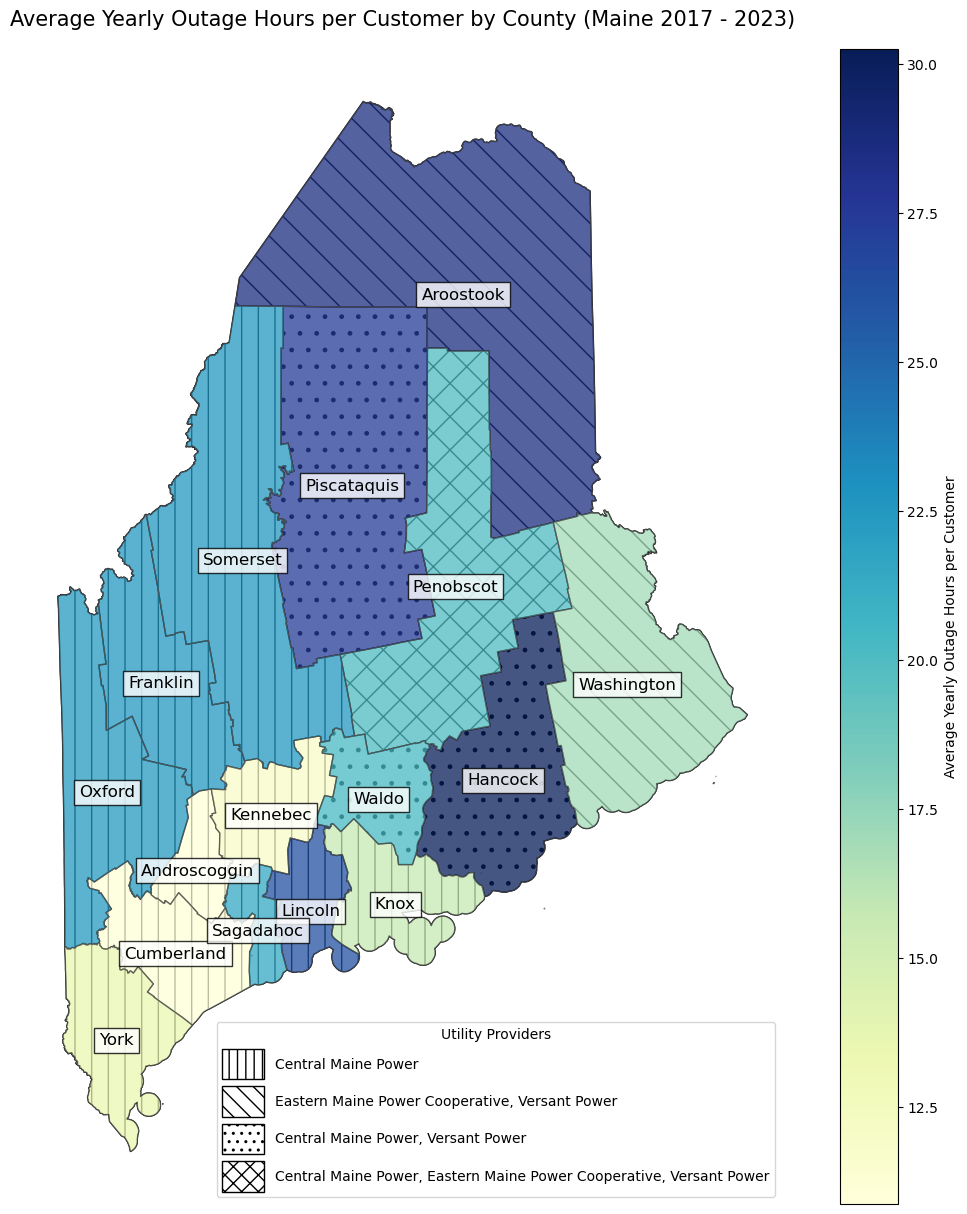

In [103]:
# import county boundaries
counties = gpd.read_file('../data/Maine_County_Boundary_Polygons_Dissolved_Feature.shp')

# merge county outage hours per customer data with geospatial data
merged = counties.set_index('COUNTY').join(overall_county_outage_df.set_index('County'))

# configure the plot size
fig, ax = plt.subplots(figsize=(15, 15))
# add hatches for different utility providers
merged.loc[merged['Utility Provider(s)'] == 'Central Maine Power'].plot(facecolor=(0, 0, 0, 0), hatch="|", edgecolor="0", ax=ax)
merged.loc[merged['Utility Provider(s)'] == 'Eastern Maine Power Cooperative, Versant Power'].plot(facecolor=(0, 0, 0, 0), hatch="\\", edgecolor="0", ax=ax)
merged.loc[merged['Utility Provider(s)'] == 'Central Maine Power, Versant Power'].plot(facecolor=(0, 0, 0, 0), hatch=".", edgecolor="0", ax=ax)
merged.loc[merged['Utility Provider(s)'] == 'Central Maine Power, Eastern Maine Power Cooperative, Versant Power'].plot(facecolor=(0, 0, 0, 0), hatch="x", edgecolor="0", ax=ax)
# plot the choropleth map using the outage hours per customer as a variable
merged.plot(column='Overall Yearly Average Outage Hours per Customer (2017 - 2023)', alpha=0.75, cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.3', legend=True, legend_kwds={'label': "Average Yearly Outage Hours per Customer", 'orientation': "vertical"})

# create custom legend of the hatches used
hatch_legend = [
    mpatches.Patch(facecolor=(0, 0, 0, 0), edgecolor="0", hatch="||", label="Central Maine Power"),
    mpatches.Patch(facecolor=(0, 0, 0, 0), edgecolor="0", hatch="\\\\", label="Eastern Maine Power Cooperative, Versant Power"),
    mpatches.Patch(facecolor=(0, 0, 0, 0), edgecolor="0", hatch="..", label="Central Maine Power, Versant Power"),
    mpatches.Patch(facecolor=(0, 0, 0, 0), edgecolor="0", hatch="xx", label="Central Maine Power, Eastern Maine Power Cooperative, Versant Power"),
]

# add the legend to the plot
ax.legend(handles=hatch_legend, title="Utility Providers", handleheight=3, handlelength=3, loc="lower right")

# add county name labels
for x, y, label in zip(merged.geometry.centroid.x, merged.geometry.centroid.y, merged.index):
    ax.text(x, y, label, fontsize=12, ha='center', va='top', bbox=dict(boxstyle='square', facecolor='white', alpha=0.8))

# axis customization
ax.set_title('Average Yearly Outage Hours per Customer by County (Maine 2017 - 2023)', fontdict={'fontsize': '15', 'fontweight' : '3'}, loc='center')
ax.axis('off')

# save the map and display it within the notebook
plt.savefig('exports/maine-county-map-overall-out-hours-per-cust.png', dpi=300)
plt.show()

### Calculate average outage hours per customer by utility provider

In [104]:
# sum up all the customers tracked and total customer hours by month and utility provider
monthly_utility_df = df.groupby(['UtilityName', 'RecordYear', 'RecordMonth']).agg({'CustomerHoursOutTotal': 'sum', 'AvgCustomersTracked': 'sum'}).reset_index()

# sum up total customer hours out by year and utility provider and average the customers tracked (to avoid double counting)
yearly_utility_df = monthly_utility_df.groupby(['UtilityName', 'RecordYear']).agg({'CustomerHoursOutTotal': 'sum', 'AvgCustomersTracked': 'mean'}).reset_index()

# get the yearly outage hours per customer for each utility provider
yearly_utility_df['OutageHoursPerCustomer'] = yearly_utility_df['CustomerHoursOutTotal'] / yearly_utility_df['AvgCustomersTracked']

# Eastern Maine Power Cooperative only has data from 2018 onwards, removing data from 2017 and earlier for consistency
yearly_utility_df.drop(yearly_utility_df[yearly_utility_df['RecordYear'] <= 2017].index, inplace=True)

# get the overall yearly average outage hours per customer by utility provider
utility_cust_outage_df = yearly_utility_df.groupby(['UtilityName']).agg({'OutageHoursPerCustomer': 'mean'}).reset_index()

# sort utility names alphabetically
utility_cust_outage_df.sort_values(by=['UtilityName'], inplace=True)

# rename columns to be more readable
utility_cust_outage_df.rename(columns={"UtilityName": "Utility Provider", "OutageHoursPerCustomer": "Overall Yearly Average Outage Hours per Customer (2018 - 2023)"}, inplace=True)

# export and show dataframe
utility_cust_outage_df.to_csv("exports/maine-utility-overall-out-hours-per-cust.csv", sep=',', encoding='utf-8', index=False, header=True)
utility_cust_outage_df

,Utility Provider,Overall Yearly Average Outage Hours per Customer (2018 - 2023)
0,Central Maine Power,17.046712
1,Eastern Maine Power Cooperative,12.042109
2,Versant Power,18.860980


### Plot average yearly outage hours per customer by utility provider 

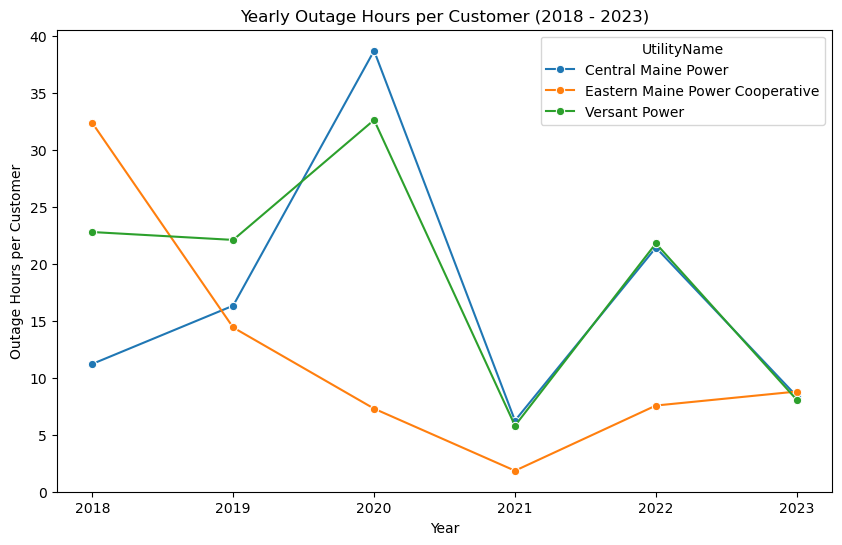

In [129]:
# sum up all the customers tracked and total customer hours by month and utility provider
monthly_utility_plot_df = df.groupby(['UtilityName', 'RecordYear', 'RecordMonth']).agg({'CustomerHoursOutTotal': 'sum', 'AvgCustomersTracked': 'sum'}).reset_index()

# sum up total customer hours out by year and utility provider and average the customers tracked (to avoid double counting)
yearly_utility_plot_df = monthly_utility_plot_df.groupby(['UtilityName', 'RecordYear']).agg({'CustomerHoursOutTotal': 'sum', 'AvgCustomersTracked': 'mean'}).reset_index()

# get the yearly outage hours per customer for each utility provider
yearly_utility_plot_df['OutageHoursPerCustomer'] = yearly_utility_plot_df['CustomerHoursOutTotal'] / yearly_utility_plot_df['AvgCustomersTracked']

# Eastern Maine Power Cooperative only has data from 2018 onwards, removing data from 2017 and earlier for consistency
yearly_utility_plot_df.drop(yearly_utility_plot_df[yearly_utility_plot_df['RecordYear'] <= 2017].index, inplace=True)

# plot the data
plt.figure(figsize=(10,6))
sns.lineplot(data=yearly_utility_plot_df, x='RecordYear', y='OutageHoursPerCustomer', hue='UtilityName', marker="o")

# add labels
plt.title('Yearly Outage Hours per Customer (2018 - 2023)')
plt.ylabel('Outage Hours per Customer')
plt.xlabel('Year')

plt.savefig('exports/utility-cust-out-hours-2018-2023.png', dpi=300)
plt.show()


